In [1]:
from pycocotools.coco import COCO
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path="/content/drive/MyDrive/Thesis/Segmentation/Mask RCNN/Mask-RCNN-finetuning-PyTorch/Internet-dataset"
images = sorted(os.listdir(file_path + "/train/image"))
masks = sorted(os.listdir(file_path + "/train/mask"))

loading annotations into memory...
Done (t=0.98s)
creating index...
index created!


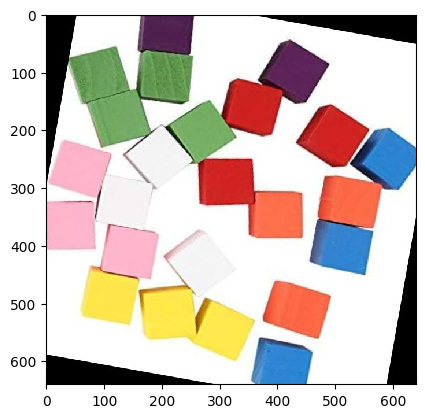

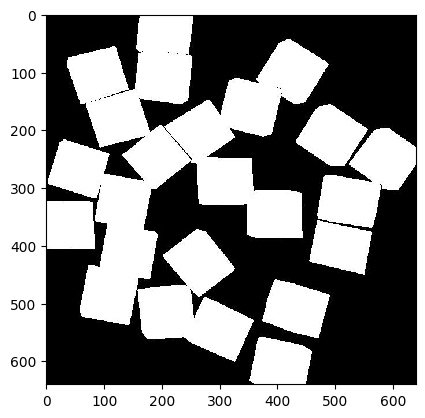

In [4]:
coco = COCO(file_path + '/train/_annotations.coco.json')
img_dir = file_path + '/train/image'
mask_dir = file_path + '/train/mask'
image_id = 9

img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

mask = coco.imgs[image_id]
mask_image = np.array(Image.open(os.path.join(mask_dir, "mask_" + img['file_name'])))
plt.imshow(mask_image, interpolation='nearest', cmap="gray")
plt.show()

In [5]:
mask_image1 = mask_image[:, :, 0]
# for checking unique values in matrix
mask_image1[mask_image1 > 1] = 1
res = list(set(i for j in mask_image1 for i in j))
# printing result
print("Unique values in matrix are : " + str(res))

Unique values in matrix are : [0, 1]


In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.images_name = sorted(os.listdir(self.file_path + "/image"))
        self.masks_name = sorted(os.listdir(self.file_path + "/mask"))

    def __getitem__(self , idx):
        img = Image.open(self.file_path + "/image/" + self.images_name[idx]).convert("RGB")
        mask = Image.open(self.file_path + "/mask/" + self.masks_name[idx])
        self.imgs = img
        mask = np.array(mask)
        mask = mask[:, :, 0]
        # for checking unique values in matrix
        mask[mask > 1] = 1
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = np.zeros((num_objs , mask.shape[0] , mask.shape[1]))
        for i in range(num_objs):
            masks[i][mask == i+1] = True
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)
        labels = torch.ones((num_objs,) , dtype = torch.int64)
        masks = torch.as_tensor(masks , dtype = torch.uint8)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        return T.ToTensor()(img) , target

    def __len__(self):
        return len(self.images_name)

In [7]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 2)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


In [8]:
transform = T.ToTensor()

In [9]:
def custom_collate(data):
  return data

In [10]:
train_dl = torch.utils.data.DataLoader(CustDat("/content/drive/MyDrive/Thesis/Segmentation/Mask RCNN/Mask-RCNN-finetuning-PyTorch/Internet-dataset/train") ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(CustDat("/content/drive/MyDrive/Thesis/Segmentation/Mask RCNN/Mask-RCNN-finetuning-PyTorch/Internet-dataset/valid") ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [13]:
params = [p for p in model.parameters() if p.requires_grad]

In [14]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [15]:
num_epoch = 100
all_train_losses = []
all_val_losses = []
flag = False
for epoch in range(num_epoch):
    print(f'epoch: {epoch}/{num_epoch}')
    train_epoch_loss = 0
    val_epoch_loss = 0
    model.train()
    for i , dt in enumerate(train_dl):
        imgs = []
        targ = []
        for l in range(len(dt)):
          imgs.append(dt[l][0].to(device))
          targ.append(dt[l][1])
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss = model(imgs , targets)
        if not flag:
            print(loss)
            flag = True
        losses = sum([l for l in loss.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    all_train_losses.append(train_epoch_loss)
    with torch.no_grad():
        for j , dt2 in enumerate(val_dl):
            imgs = []
            targ = []
            for l in range(len(dt2)):
              imgs.append(dt2[l][0].to(device))
              targ.append(dt2[l][1])
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(imgs , targets)
            losses = sum([l for l in loss.values()])
            val_epoch_loss += losses.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
    print(epoch , "  " , train_epoch_loss , "  " , val_epoch_loss)

epoch: 0/100
{'loss_classifier': tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(7.5918e-05, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.3845, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.6846, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>)}
0    62.513925671577454    4.6190720200538635
epoch: 1/100
1    48.090870171785355    4.676944017410278
epoch: 2/100
2    48.19338220357895    5.087579429149628
epoch: 3/100
3    40.62458145618439    3.944794237613678
epoch: 4/100
4    31.156138449907303    3.544805407524109
epoch: 5/100
5    26.93855705857277    3.8532812893390656
epoch: 6/100
6    27.360814407467842    3.6408609449863434
epoch: 7/100
7    26.81801876425743    3.4561261236667633
epoch: 8/100
8    22.125583320856094    2.8868468105793
epoch: 9/100
9    21.48774543404579

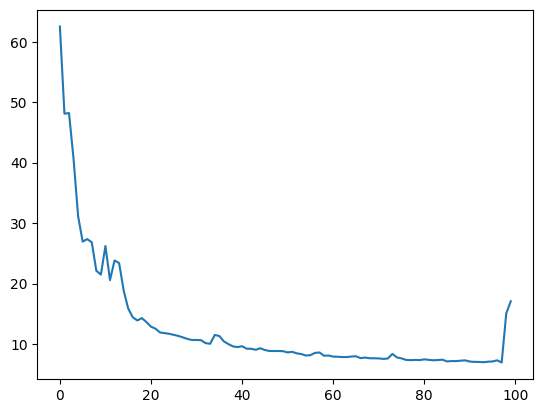

In [16]:
plt.plot(all_train_losses)

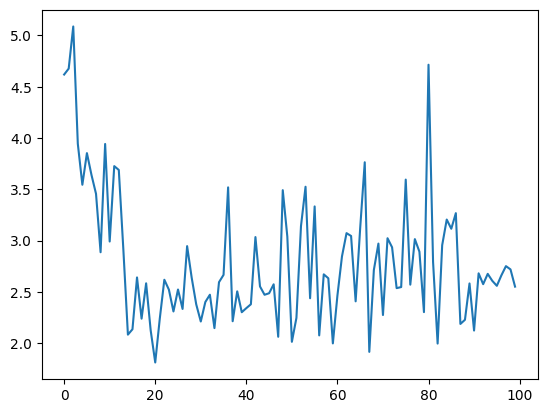

In [17]:
plt.plot(all_val_losses)

In [18]:
model.eval()
img = Image.open(file_path + "/test/image/16_jpg.rf.f28650c68194d79c9998f93809c7abb8.jpg")
transform = T.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

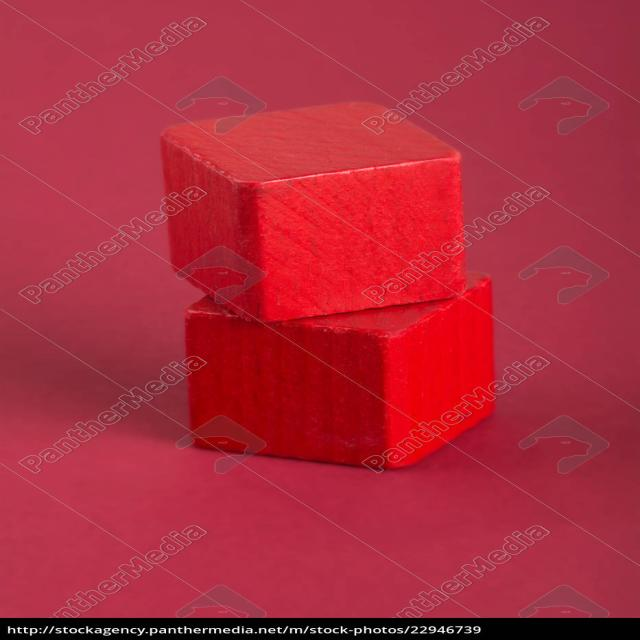

In [19]:
img

In [20]:
pred

[{'boxes': tensor([[114.7562,   0.0000, 640.0000, 547.4518],
          [  4.9698,  16.4386, 386.4661, 617.8904]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9982, 0.9542], device='cuda:0'),
  'masks': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.3022, 0.2772, 0.2523],
            [0.0000, 0.0000, 0.0000,  ..., 0.3333, 0.3058, 0.2782],
            [0.0000, 0.0000, 0.0000,  ..., 0.3644, 0.3343, 0.3042],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
  
  
          [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            ...,
            [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
            [0.0000, 0.0000, 0.0000, 

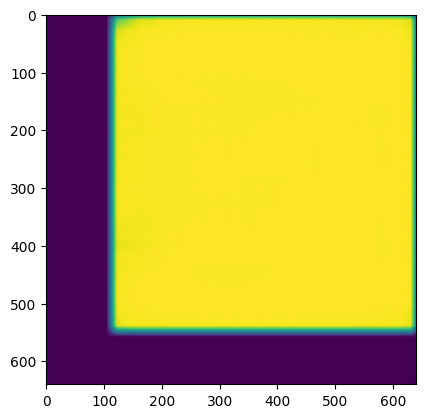

In [21]:
plt.imshow((pred[0]["masks"][0].cpu().detach().numpy() * 255).astype("uint8").squeeze())